# How to run BELLHOP

Models in the Ocean Acoustics Toolbox stores environmental parameters in a ".env" file.  This tutorial will describe the various parameters and how they are set.  The following can be repeated as many times as wanted in a single ENVFIL. KRAKEN and KRAKENC will generate a separate MODFIL for each case stopping when it detects an end-of-file.

In [1]:
import os
import sys
sys.path.append("/Users/williamjenkins/Research/Code/TritonOA/")

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from TritonOA.io import env
from TritonOA.io import readwrite

## Block 1: Title

Syntax:
>*TITLE*

Description:
>TITLE: Title of run enclosed in sinqle quotes.

In [2]:
TITLE = 'TEST_BELLHOP'

## Block 2: Frequency

Syntax:
>*FREQ*

Description:
>FREQ: Frequency in Hz.

In [3]:
FREQ = 11000

## Block 3: Number of Media

Syntax:
>*NMEDIA*

Description:
>NMEDIA: Number of media.
<p>The problem is divided into media within which it is assumed that the material properties vary smoothly. A new medium should be used at fluid/elastic interfaces or at interfaces where the density changes discontinuously. The number of media in the problem is defined excluding the upper and lower half-space.
<p>BELLHOP is limited to one medium (NMEDIA=1) and actually ignores this parameter.

In [4]:
NMEDIA = 1

## Block 4: Top Option

Syntax:
>*TOPOPT*

Description:
>TOPOPT(1:1): Type of interpolation to be used for the SSP.
>>'C' for C-linear,
<br>'N' for N2-linear (n the index of refraction),
<br>'P' for PCHIP (Piecewise Cubic Hermite Interpolating Polynomial),
<br>'S' for cubic Spline,
<br>'Q' for Quadrilatteral 2D SSP (BELLHOP   only; reads the SSP from a file)
<br>'H' for Hexahedral     3D SSP (BELLHOP3D only; reads the SSP from a file)
<br>'A' for Analytic.
<br>The user must modify the analytic formulas in ANALYT.FOR then re-compile and link.
<br>
<br>If you're not sure which option to take, I'd suggest you use 'C'.  The 'N' option is virtually identical to 'C'. It's provided to facilitate precise inter-model comparisons with codes that use a certain numerical technique that requires that type of interpolation. Both these piecewise-linear approximations can produce false caustics in BELLHOP; however, the Gaussian beam option in BELLHOP mitigates that effect to some degree.
<br>
<br>Option 'S' is a little dangerous because splines yield a poor fit to certain kinds of curves, e.g. curves with sharp bends.  If you insist on splines, you can fix a bad fit by dividing the water column into two 'media' at the bend.
<br>
<br>Option 'P' is a recently added option that is intended to provide a smooth interpolation without the artifacts that sometimes come with cubic splines. We will need to get some more experience with this, but the expectation is that this will often be the best choice for BELLHOP by providing a smoother profile free of false caustics.
<br>
<br>If 'A' is selected, then only the first line of block (5) for the SSP is used and the tabulated SSP itself is omitted.
<br>
<br>Run PLOTSSP to check that the SSP looks the way you thought it should. Apart from potential typos, this will also show up fit-problems.

>TOPOPT(2:2): Type of top boundary condition
>>'V' VACUUM above top
<br>'A' ACOUSTO-ELASTIC half-space.
<br>Requires another line with the halfspace parameters as described in block (4a).
<br>'R' Perfectly RIGID
<br>'F' Reflection coefficient from a FILE
<br>
<br>These files for complicated, multi-layered media can be generated using BOUNCE. (Available in KRAKENC, SCOOTER, and BELLHOP. Not available in KRAKEN and SPARC.) For a Top Reflection Coefficient, the file should have the extension '.TRC'. For KRAKEN/KRAKENC this option for tabulated reflection coefficients is somewhat experimental at this time. A complicated reflection coefficient may well cause problems for the mode-finder. Finally, a reflection coefficient tabulated only for real angles does not provide a good result for complex angles of incidence. This happens when the sediment sound speed is less than the water sound speed. In that case, the modes are evanescent in the upper part of the water column and therefore have a complex angle of incidence.
<br>
<br>For open ocean problems option 'V' should be used for the top BC.

>TOPOPT(3:3): Attenuation units.
>>'N' Nepers/m.
<br>'F' dB/(kmHz)       (F as in Freq. dependent)
<br>'M' dB/m            (M as in per Meter)
<br>'m' dB/m            (m as in per Meter) Scaled with frequency; quadratically, then linearly above fT
<br>'W' dB/wavelength   (W as in per Wavelength)
<br>'Q' quality factor
<br>'L' Loss parameter (a.k.a. loss tangent)
<br>
<br>KRAKEN ignores material attenuation in elastic media. (KRAKENC treats it properly).
The option 'm' for attenuation is a new one designed to capture a power-law frequency dependence. You provide an attenuation in dB/m at the frequency specified above (FREQ). Then in a broadband run, with multiple frequencies that attenuation as automatically scaled according to the power that you specify.
<br>
<br>***The power-law scaling is based on the frequency to a power beta, up to a transition frequency, fT. Above fT, the scaling is linear with frequency. The parameters that control this are specified in the first line of block (5) and block (6) and allow a different beta and fT to be specified independently for every layer. The actual attenuation in dB/m is the value at the reference frequency given in block (2) above.***
<br>
<br>If you use 'm' without doing a broadband run, then 'M' and 'm' will do the same thing, i.e. interpret your attenuation as dB/m at the given frequency.

>TOPOPT(4:4): Added volume attenuation.
>>'T' Thorp attenuation formula.
<br>'F' Francois-Garrison formula (more accurate).
<br>'B' Biological layer (fish).
<br>
<br>If you invoke this option, volume attenuation is added to the explicitly specified attenuation (ap, as).
The Francois-Garrison formula depends on salinity (S), temperature (T), pH, and depth (z_bar). That information is then provided on the line immediately following, e.g.:
<br>`   19.3 33.5 7.5 4000.7   !  T, Salinity, pH, z_bar`

>TOPOPT(5:5): Altimetry option; Slow/robust root-finder.
>>'~' Read in a *.ati file containing the top altimetry. (BELLHOP only; '*' was used earlier and still works)
<br>'_' Flat surface, i.e. no altimetry file. (BELLHOP only; this is the default if blank)
<br> '.' As in: I want all the modes and I don't care how long it takes. Period.
<br>
<br>The '.' option works only with KRAKENC, which sometimes has trouble finding a complete set of modes in the complex plane.

>TOPOPT(6:6): Single beam (BELLHOP only)
>>'I' Calculate only a single beam from the specified fan.
<br>    The actual beam number is specified after NBEAMS, under
<br>    the section describing the beam fan.
<br>' ' Default: trace all beams
<br>
<br>Broadband run (currently implemented in KRAKEN and SCOOTER)
<br>'B' Select a broadband run where multiple frequencies are specified

>TOPOPT(7:7): Use 0 (zero) to disable stabilizing attenuation in SCOOTER

In [5]:
TOPOPT = "CVF"

### Block 4a: Top Halfspace Properties

Syntax:
>ZT  CPT  CST  RHOT  APT  AST

Description:
>ZT:   Depth (m).
<br>CPT:  Top P-wave speed (m/s).
<br>CST:  Top S-wave speed (m/s).
<br>RHOT: Top density (g/cm3).
<br>APT:  Top P-wave attenuation. (units as given by Option(3:3) )
<br>AST:  Top S-wave attenuation. (  "   "    "    "   "   "     )

This line should only be included if TOPOPT(2:2)='A', i.e. if the user has specified a homogeneous halfspace for the top BC.

In [6]:
top_halfspace_flag = False
if top_halfspace_flag:
    ZT = 0
    CPT = 0
    CST = 0
    RHOT = 0
    APT = 0
    AST = 0

### Block 4b: Biological Layer Parameters (for attenuation due to fish)

Syntax:
>NBioLayers
<br>Z1(1)  Z2(1)  f0(1)   Q(1)   a0(1)
<br>Z1(2)  Z2(2)  f0(2)   Q(2)   a0(2)
<br>...
<br>Z1(NBioLayers)  Z2(NBioLayers)  f0(NBioLayers)   Q(NBioLayers)   a0(NBioLayers)

Description:
>z1: Top    of layer (m)
<br>z2: Bottom of layer (m)
<br>f0: Resonance frequency (Hz)
<br>Q:  Quality factor
<br>a0: Amplitude in dB/km at resonance but scaled by Q^2
<br>
<br>The loss becomes a = a0 / [ ( 1 - f0^2 / freq^2 )^2 + 1 / Q^2 ] dB / km (formula suggested by Orest Diachok).
<br>The units here in dB/km are not affected by the attenuation units selected in TopOpt( 3 : 3 ).

In [7]:
# Not implemented.

## Block 5: Sound Speed Profile

Syntax:
>NMESH  SIGMA  Z(NSSP)
<br>Z(1)     CP(1)     CS(1)     RHO(1)     AP(1)     AS(1)
<br>Z(2)     CP(2)     CS(2)     RHO(2)     AP(2)     AS(2)
<br>...
<br>Z(NSSP)  CP(NSSP)  CS(NSSP)  RHO(NSSP)  AP(NSSP)  AS(NSSP)

Description:
>NMESH:   Number of mesh points used in the internal discretization.
>>The number of mesh points should be about 10 per vertical wavelength in acoustic media. In elastic media, the number needed can vary quite a bit; 20 per wavelength is a reasonable starting point. For elastic media, the wavelength associated with the shear wave speed is the reference; this is always shorter than that for the p-wave.
<br>
<br>The number of mesh points used depends on the initial mesh and the number of times it is refined (doubled). <br>The number of mesh doublings can vary from 1 to 5 depending on the parameter RMAX described below.
<br>
<br>If you type 0 for the number of mesh points, the code will calculate NMESH automatically.
<br>
<br>BELLHOP ignores this parameter as it's not relevant to its numerical technique.

>SIGMA:   RMS roughness at the interface (ignored by BELLHOP and SPARC)

>Z(NSSP): Depth at bottom of medium (m).
>>This value is used to detect the last SSP point when reading in the profile that follows/

>Z():     Depth (m).
>>The surface starts at the first depth point specified. Thus if you have say, XBT data which starts at 50 m below the surface, then you'll need to put in some SSP point at 0 m, otherwise the free-surface would be placed at 50 m giving erroneous results. The points Z(1) and Z(NSSP) MUST correspond to the depths of interfaces between media.

>***If the attenuation units were specified with option letter 'm' and a broadband run is selected, then the attenuation is scaled with frequency. The scaling is based on the frequency to a power beta, up to a transition frequency, fT. Above fT, the scaling is linear with frequency. The parameters that control this are specified in the first line of this block using the syntax:***
>>NMESH  SIGMA  Z(NSSP)  beta  fT
<br>
<br>where,
<br>BETA:  Power for the power law
<br>fT:  Transition frequency (Hz)

>CP():    P-wave speed (m/s).

>CS():    S-wave speed (m/s).

>RHO():   Density (g/cm3).
>>Density variations within an acoustic medium are at present ignored.

>AP():    P-wave attenuation (units as given in Block 2)

>AS():    S-wave attenuation (  "   "    "    "   "   ")

>These lines giving the SSP should be omitted when the 'A' option is used (indicating that an analytic profile is supplied by a user written subroutine).
<br>
<br>The '/' character signals that the remaining data on the line is the same as in the previous line of SSP data. For the very first line the default or 'previous' line is:
<br>`0.0 1500.0 0.0 1.0 0.0 0.0`
<br>
<br>This block should be repeated for each subsequent medium.
<br>
<br>Only KRAKEN, SCOOTER, and BOUNCE can use the shear wave information. SPARC and BELLHOP ignore it.

In [8]:
NMESH = 1500
SIGMA_TOP = 0.5
ZB = 1500

SSP_TYPE = "read"

Z = np.linspace(0,ZB,NMESH)
if SSP_TYPE == "isospeed":
    CP = 1500 * np.ones(Z.shape)
elif SSP_TYPE == "positive":
    CP = np.linspace(1440, 1500, NMESH)
elif SSP_TYPE == "negative":
    CP = np.linspace(1525, 1475, NMESH)
elif SSP_TYPE == "defined":
    CP = np.zeros(Z.shape)
elif SSP_TYPE == "read":
    df = pd.read_csv("/Users/williamjenkins/Documents/SIO/Travel/2021 Norway UAK/Acoustic_positioning_exercise/Software/XBT.csv")
    Z_BT = np.array(df.Var1)
    CP_BT = np.array(df.Var2)
    f = interp1d(Z_BT, CP_BT)
    CP = f(Z)
    CP[0:5] = 1442

CS = 0 * np.ones(Z.shape)
RHO = 1.035 * np.ones(Z.shape)
AP = 0 * np.ones(Z.shape)
AS = 0 * np.ones(Z.shape)

ssp = env.SSPraw(Z, CP, CS, RHO, AP, AS)

## Block 6: Bottom Option

Syntax:
>*BOTOPT SIGMA*

or, if the power-law attenuation option 'm' was selected:
>*BOTOPT  SIGMA BETA fT*

Description:
>BOTOPT(1:1): Type of bottom boundary condition.
>>'V' VACUUM below bottom.
<br>'A' ACOUSTO-ELASTIC half-space. Requires another line with the half-space parameters as described in Block (6a).
<br>'R' Perfectly RIGID.
<br>'G' Grain size
<br>'F' Reflection coefficient from a FILE
<br>
<br>These files for complicated, multi-layered media can be generated using BOUNCE. (Available in KRAKENC, SCOOTER, and BELLHOP. Not available in KRAKEN and SPARC.) For a Bottom Reflection Coefficient, the file should have the extension '.BRC'. For KRAKEN/KRAKENC this option for tabulated reflection coefficients is somewhat experimental at this time. A complicated reflection coefficient may well cause problems for the mode-finder. Finally, a reflection coefficient tabulated only for real angles does not provide a good result for complex angles of incidence. This happens when the sediment sound speed is less than the water sound speed. In that case, the modes are evanescent in the upper part of the water column and therefore have a complex angle of incidence.
<br>
<br>'P' Precaculated internal reflection coefficient from a FILE (available in KRAKENC and SCOOTER, not KRAKEN).
    These files are generated using BOUNCE.
<br>
<br>Option 'A' is generally used for ocean bottom modeling.

>BOTOPT(2:2):
>>    '~' Read in a *.bty file containing the bottom bathymetry. (BELLHOP only; '*' was used earlier and still works)
<br>    '_' Flat surface, i.e. no bathymetry file. (BELLHOP only; this is the default if blank)

>SIGMA:  Interfacial roughness (m).

>BETA:   Power for the power law

>fT:     Transition frequency (Hz)

In [9]:
BOTOPT = "A"
SIGMA_BOT = 0.5

### Block 6b: Bottom Halfspace Properties from geoacoustic values

Syntax:
>*ZB  CPB  CSB  RHOB  APB  ASB*

Description:
>ZB:   Depth (m).

>CPB:  Bottom P-wave speed (m/s).

>CSB:  Bottom S-wave speed (m/s).

>RHOB: Bottom density (g/cm3).

>APB:  Bottom P-wave attenuation. (units as given by TOPOPT(3:3) )

>ASB:  Bottom S-wave attenuation. (  "   "    "    "   "   "     )

This line should only be included if BOTOPT(1:1)='A', i.e. if the user has specified a homogeneous halfspace for the bottom BC.
 
These lines should be contained in a separate '.BRC' file. This file is only required if BOTOPT(2:2)='F', i.e. if the user has specified that the bottom BC is read from a '.BRC' (Bottom Reflection Coefficient) file.

For KRAKEN/KRAKENC this option for tabulated reflection coefficients is somewhat experimental at this time. A complicated reflection coefficient may well cause problems for the mode-finder. Finally, a reflection coefficient tabulated only for real angles does not provide a good result for complex angles of incidence. This happens when the sediment sound speed is less than the water sound speed. In that case, the modes are evanescent in the upper part of the water column and therefore have a complex angle of incidence.

In [10]:
CPB = 5000
CSB = 0
RHOB = 3.8
APB = 0.2
ASB = 0

### Block 6c: Bottom Halfspace Properties from grain size

Syntax:
>*ZB  MZ*

Description:
>ZB:  Depth (m).

>MZ:  Grain size (phi units).

This line should only be included if BOTOPT(1:1)='G', i.e. if the user has specified a homogeneous halfspace for the bottom BC defined by grain size. The bottom sound speed, attenuation, and density is calculated using formulas from the UW_APL High-Frequency handbook.

---
## Append model-specific parameters:

---
### BELLHOP

### Block 7: Source/Receiver Depths and Ranges
Syntax:
>*NSD*
<br>*SD(1:NSD)*
<br>*NRD*
<br>*RD(1:NRD)*
<br>*NR*
<br>*R(1:NR)*

Description:
>NSD: The number of source depths
<br>SD(): The source depths (m)
<br>NRD:  The number of receiver depths
<br>RD(): The receiver depths (m)
<br>NR:   The number of receiver ranges
<br>R():  The receiver ranges (km)
<br>
<br>This data is read in using list-directed I/O you can type it just about any way you want, e.g. on one line or split onto several lines.  Also if the depths or ranges are equally spaced then you can type just the first and last depths followed by a '/' and the intermediate depths will be generated automatically.
<br>
<br>You can specify a receiver at zero range; however, the BELLHOP field is singular there--- the pressure is returned as zero.
<br>
<br>Some of the subroutines that calculate the beam influence allow an arbitrary vector of receiver ranges; others require it to be equally spaced in range. In particular, only the following allow an arbitrary range vector:
<br>
<br>'G' GeoHatCart
<br>'B' GeoGaussianCart
<br>CerveyRayCen

In [11]:
NSD = 1
SD = 15.5

NRD = NMESH
RD = 1

NR = 1
R = 5

### Block 8: Run Type
Syntax:
>*OPTION*

Description:
>OPTION(1:1):
<br>'R' generates a ray file
<br>'E' generates an eigenray file
<br>'A' generates an amplitude-delay file (ascii)
<br>'a' generate  an amplitude-delay file (binary)
<br>'C' Coherent     TL calculation
<br>'I  Incoherent   TL calculation
<br>'S' Semicoherent TL calculation
<br>(Lloyd mirror source pattern)

>OPTION(2:2):
<br>'G' Geometric hat beams in Cartesian coordinates (default)
<br>'g' Geometric hat beams in ray-centered coordinates
<br>'B' Geometric Gaussian beams

>OPTION(3:3): '*' read in a source beam pattern file
<br>'O' don't (default)

>OPTION(4:4): 'R' point source (cylindrical coordinates) (default)
                       'X' line  source (cartesian coordinates)

>OPTION(5:5): 'R' rectilinear grid (default)
                       'I' irregular grid

>The ray file and eigenray files have the same simple ascii format and can be plotted using the Matlab script plotray.m.
<br>
<br>The eigenray option seems to generate a lot of questions. The way this works is that BELLHOP simply writes the trajectories for all the beams that contribute at a given receiver location. To get a useful picture you normally want to use a very fine fan, only one receiver location, and the geometric beam option. See the examples in at/tests.
<br>
<br>The amplitude-delay file can be used with the Matlab script stackarr.m to 'stack the arrivals', i.e. to convolve them with the source spectrum and plot the channel response. stackarr.m can also be used to simple plot the impulse response. We loosely refer to the amplitudes of the arrivals or echoes here; however, these values are really complex numbers that provide the amplitude and phase of each echo.
<br>
<br>For TL calculations, the output is in the shdfil format used by all the codes in the Acoustics Toolbox and can be plotted using the Matlab script, plotshd.m. (Use toasc.f to convert the binary shade files to ascii format for use by plotshd.m or whatever plot package you're using.)
<br>
<br>The pressure field is normally calculated on a rectilinear grid formed by the receiver ranges and depths. If an irregular grid is selected, then the receiver ranges and depths are interpreted as a coordinate pair for the receivers. This option is useful for reverberation calculations where the receivers need to follow the bottom terrain. This option has not been used much. The plot routines (plotarr) have not been modified to accomodate it. There may be some other limitations.
<br>
<br>There are actually several different types of Gaussian beam options (OPTION(2:2)) implemented in the code. Only the two described above are fully maintained.
<br>
<br>The source beam pattern file has the format
<br>
<br>       NSBPPts
<br>       angle1  power1
<br>       angle2  power2
<br>        ...
<br>with angle following the BELLHOP convention, i.e. declination angle in degrees (so that 90 degrees points to the bottom). The power is in dB. To match a standard point source calculation one would used anisotropic source with 0 dB for all angles. (See at/tests/BeamPattern for an example.)

In [12]:
RUN_TYPE = "I"

### Block 9: Beam Fan
Syntax:
>*NBEAMS ISINGLE*
<br>*ALPHA(1:NBEAMS)*

Description:
>NBEAMS: Number of beams (use 0 to have the program calculate a value automatically, but conservatively).

>ISINGLE: If the option to compute a single beam in the fan is selected (top option) then this selects the index of the beam that is traced.

>ALPHA(): Beam angles (negative angles toward surface)

>For a ray trace you can type in a sequence of angles or you can type the first and last angles followed by a '/'.  For a TL calculation, the rays must be equally spaced otherwise the results will be incorrect.

In [13]:
NBEAMS = 0
ALPHA = np.linspace(-90, 90, 181)

### Block 10: Beam Fan
Syntax:
>*STEP ZBOX RBOX*

Description:
>STEP:  The step size used for tracing the rays (m). (Use 0 to let BELLHOP choose the step size.)

>ZBOX:  The maximum depth to trace a ray        (m).

>RBOX:  The maximum range to trace a ray       (km).

>The required step size depends on many factors.  This includes frequency, size of features in the SSP (such as surface ducts), range of receivers, and whether a coherent or incoherent TL calculation is performed.  If you use STEP=0.0 BELLHOP will use a default step-size and tell you what it picked.  You should then halve the step size until the results are convergent to your required accuracy.  To obtain a smooth ray trace you should use the spline SSP interpolation and a step-size less than the smallest distance between SSP data points. Rays are traced until they exit the box ( ZBOX, RBOX ).  By setting ZBOX less than the water depth you can eliminate bottom reflections. Make ZBOX, RBOX a bit (say 1%) roomy too make sure rays are not killed the moment they hit the bottom or are just reaching your furthest receiver.
<br>
<br>The default step size has generally been OK; however, with the paraxial (Cerven) beams it was too aggressive on one simple test. The paraxial beams are generally much wider than the geometric beams so a given receiver gets contributions from beams with much more distance to the central ray. It is assumed that that increases the sensitivity to the accuracy of the ray trace (and its normals) which determine the phase of these distant beams as observed at the receive.

In [14]:
STEP = 0
ZBOX = ZB
RBOX = 10

### Write environment file:

In [15]:
top = env.TopBndry(TOPOPT)
halfspace = env.HS(CPB, CSB, RHOB, APB, ASB)
bottom = env.BotBndry(BOTOPT, halfspace)
bdy = env.Bndry(top, bottom)

depth = [0, ZB]
ssp_list = [ssp]
NMESH = [NMESH]
sigma = [SIGMA_TOP, SIGMA_BOT] # Roughness at each layer; only affects attenuation (imag. part)
ssp = env.SSP(ssp_list, depth, NMEDIA, TOPOPT, NMESH, sigma)

CLOW = 0
CHIGH = CPB
cInt = env.cInt(CLOW, CHIGH)

RMAX = RBOX

# Beam params
box = env.Box(ZBOX, RBOX)
beam = env.Beam(RunType=RUN_TYPE, Nbeams=NBEAMS, alpha=ALPHA, box=box, deltas=STEP)

s = env.Source([SD])
X = np.arange(0, RMAX, 0.01)
r = env.Dom(X, Z)
pos = env.Pos(s,r)
# pos.s.depth = [SD]
pos.Nsd = NSD
pos.Nrd = NRD

readwrite.write_env(f"{TITLE}.env", "BELLHOP", TITLE, FREQ, ssp, bdy, pos, beam, cInt, RMAX)

0


In [16]:
readwrite.write_fieldflp(TITLE, "R", pos)

In [17]:
os.system(f"bellhop.exe {TITLE}")

0

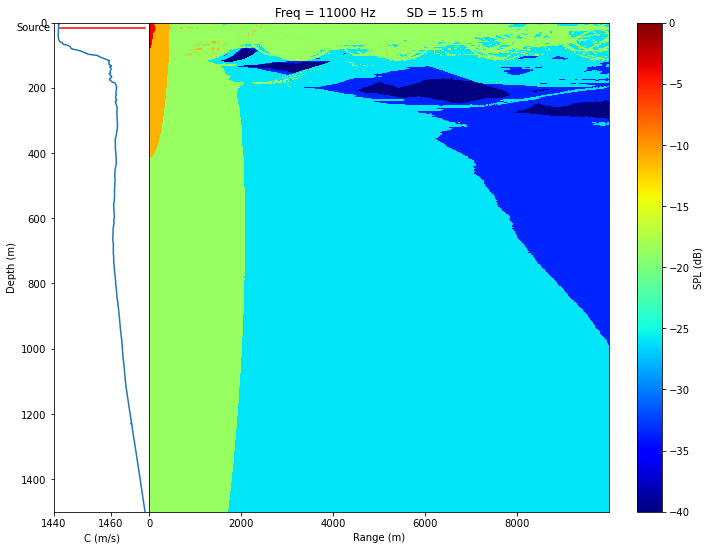

In [18]:
# [x, x, x, x, Pos1, pressure] = readwrite.read_shd(f"{TITLE}.shd")
# pressure = abs(pressure)
# pressure[pressure == 0] = 1e-30
# pressure = 10 * np.log10(pressure / np.max(pressure))
# levs = np.linspace(np.min(pressure), np.max(pressure), 40)

# plt.contourf(Pos1.r.range, Pos1.r.depth, (pressure[0, 0, :, :]), levels=levs)
# # plt.imshow(pressure[0, 0, :, :])
# plt.gca().invert_yaxis()
# plt.xlabel("Range (m)")
# plt.ylabel("Depth (m)")
# plt.show()

[x, x, x, x, Pos1, pressure] = readwrite.read_shd(f"{TITLE}.shd")
pressure = abs(pressure)
pressure[pressure == 0] = 1e-30
pressure = 10 * np.log10(pressure / np.max(pressure))
levs = np.linspace(np.min(pressure), np.max(pressure), 40)

fig = plt.figure(figsize=(12,9))
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0, width_ratios=[1, 6])

ax1 = fig.add_subplot(gs[0])
ax1 = plt.subplot(1, 2, 1)
plt.plot(CP, Z)
plt.plot(CP[[0, -1]], [SD, SD], 'r')
ax1.invert_yaxis()
plt.ylim(ZB,0)
plt.xlabel("C (m/s)")
plt.ylabel("Depth (m)")
plt.text(CP[0]-15, SD, "Source", va="center")

ax2 = fig.add_subplot(gs[1])
vmin = -40
vmax = 0
plt.contourf(Pos1.r.range, Pos1.r.depth, (pressure[0, 0, :, :]), levels=levs, cmap="jet", vmin=vmin, vmax=vmax)
# plt.imshow(pressure[0, 0, :, :])
plt.gca().invert_yaxis()
plt.yticks([])
plt.xlabel("Range (m)")
# plt.ylabel("Depth (m)")
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_spec))
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="jet"))
cbar.set_label("SPL (dB)")
plt.scatter(0, SD, s=500, c="r", marker=".")

plt.title(f"Freq = {FREQ} Hz        SD = {SD} m")

plt.show()